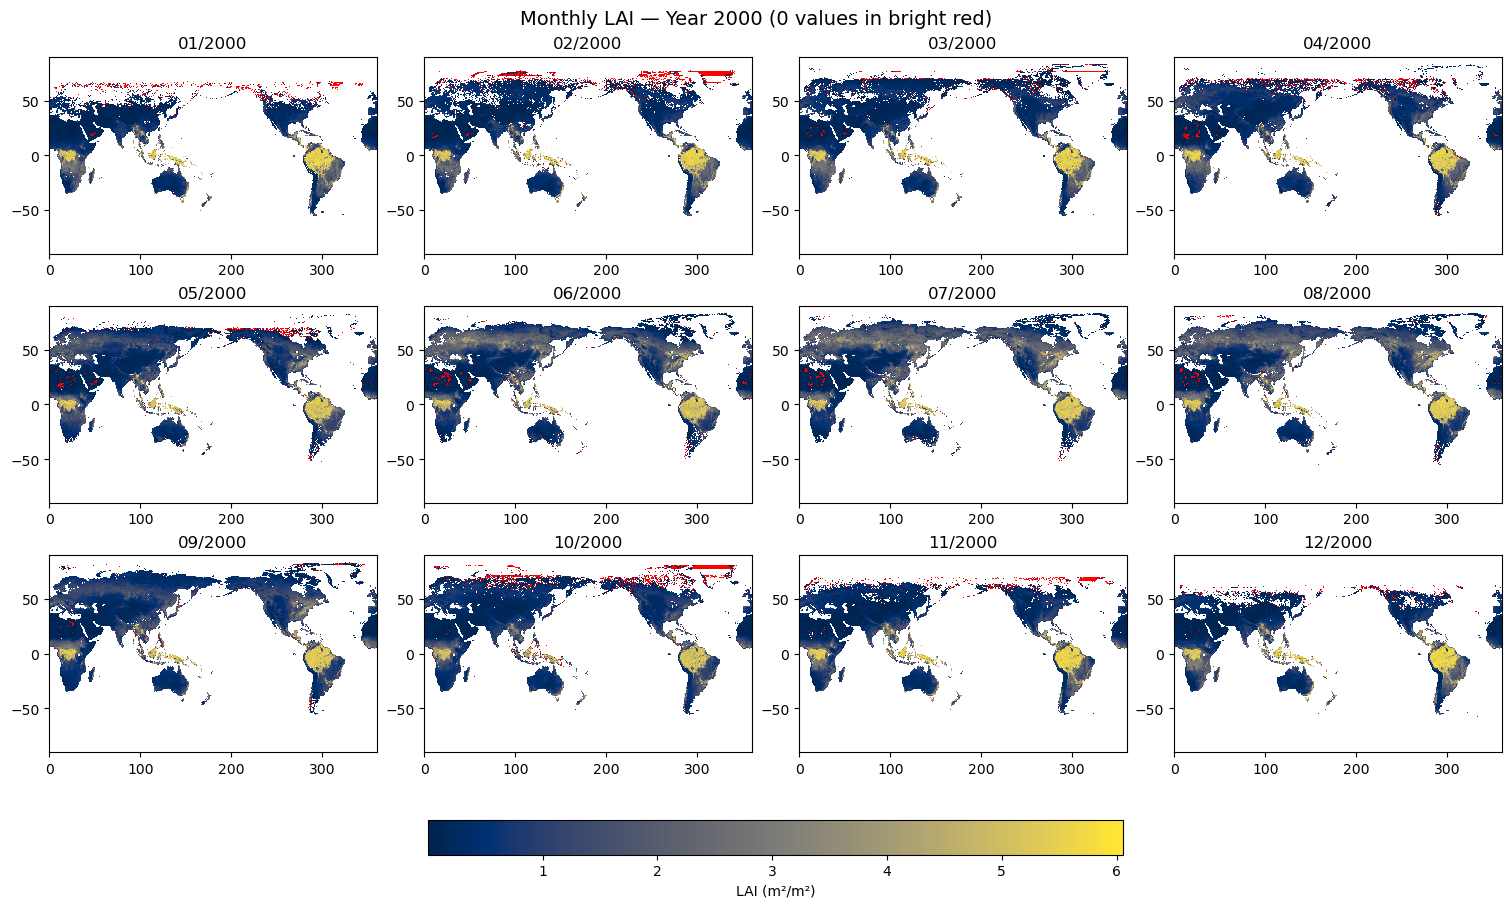

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from matplotlib.colors import ListedColormap

# ------------------------------------------------------------
# Load dataset
# ------------------------------------------------------------
path = Path("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preprocessed/transfer_learning/avh15c1/lai_avh15c1.nc")
ds = xr.open_dataset(path)  # if needed: xr.open_dataset(path, use_cftime=True)
da = ds["lai_avh15c1"].where(ds["lai_avh15c1"] != -999)

# Select year 2000 (works for daily or monthly data)
is_2000 = da["time"].dt.year == 2000
da_2000 = da.sel(time=is_2000)

# Common color scale (ignore NaNs). If you want to ignore zeros for scaling:
finite_nonzero = da_2000.where(da_2000 != 0)
vmin = float(finite_nonzero.min())
vmax = float(finite_nonzero.max())

# ------------------------------------------------------------
# Plot: base = cividis, zeros overlaid in bright red
# ------------------------------------------------------------
fig, axes = plt.subplots(3, 4, figsize=(15, 9), constrained_layout=True)
axes = axes.ravel()

for i, month in enumerate(range(1, 12+1)):
    ax = axes[i]
    # subset to this month, average in case multiple timesteps exist
    sub = da_2000.sel(time=da_2000["time"].dt.month == month)
    if "time" in sub.dims:
        sub = sub.mean("time")

    # Base layer: nonzero values in cividis
    base = sub.where(sub != 0)
    im = base.plot(ax=ax, cmap="cividis", vmin=vmin, vmax=vmax, add_colorbar=False)

    # Overlay: zeros in bright red (single-color colormap)
    zero_mask = xr.where(sub == 0, 1.0, np.nan)
    if np.isfinite(zero_mask).any():
        zero_cmap = ListedColormap([[1, 0, 0, 1]])  # bright red
        zero_mask.plot(ax=ax, cmap=zero_cmap, add_colorbar=False)

    ax.set_title(f"{month:02d}/2000")
    ax.set_xlabel("")
    ax.set_ylabel("")

# One shared colorbar for cividis layer
cbar = fig.colorbar(im, ax=axes.tolist(), orientation="horizontal", fraction=0.05, pad=0.06)
cbar.set_label("LAI (m²/m²)")
plt.suptitle("Monthly LAI — Year 2000 (0 values in bright red)", fontsize=14)
plt.show()